<div style="background:#FFFFAA">
<img src="logo.jpg", width=150, ALIGN="left", border=20>
    <h1>Team GAIASAVERS</h1>
    <h3>Alban Petit, Wafa Bouzouita,Timothée Babinet, Maxime Chor, Eric Wang, Sebastien Warichet</h3>
    <h2>Plankton classification challenge</h2>

<br>This code was tested with <br>
Python 3.7 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) (https://anaconda.org/)<br>
<i> Adapted for Chalab by Isabelle Guyon from original code of Balázs Kégl</i> <br>
<a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science (CDS)</a>
</center>
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
     <br>
       
According to [NRMA15], a link has been found between the quality of water and the presence of plankton in said water. As water quality increases, the abundance and diversity of plankton does as well. The aim of our project is to build a plankton classifier to assess water quality.

We use for this problem the Bering Sea dataset, an in situ plankton dataset published in May 2019 by Kaichang Cheng [Che19]. This datset contains 7 classes with an even spread.

        
References and credits: 
- [NRMA15] A. Nair, J.K. Reshma, A. Mathew, and A. Ashok. Effect of water quality on phytoplankton abundance in selected ponds of nedumangad block panchayat, kerala. Emer Life Sci Res, 2015.
- [Che19] K. Cheng. Bering sea dataset. https://doi.org/10.6084/m9.figshare.8146283.v3, 2019.
 <br>
</div>

<img src="images/sample.png" alt="Drawing"/>
To see more images for each class, see the "images" folder.

In [1]:
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red"> Just change the data name in the block below. In the rest of the section, replace the sample plots by anything you want. </span>
</div>

In [2]:
#data_dir = 'sample_data'              # Change this to the directory where you put the input data
data_dir = './public_data'          # The sample_data directory should contain only a very small subset of the data
data_name = 'plankton'
!ls $data_dir*

plankton_feat.name    plankton_test.data       plankton_valid.data
plankton_label.name   plankton_train.data
plankton_public.info  plankton_train.solution


<h3>Two "feature representation"</h3>

<p>
1.
All of the images are in various shades of gray. As such, we can represent every image by a vector of 90000 (300x300) features where each feature is a float value between 0 and 255 representing the brightness of a pixel (0 being a black pixel and 255 a white one). It is also possible to reduce the size of the images to reduce the number of features as seen in figure 3 where we reduced the size to 100x100 pixels.
</p>

<tr>
    <td> <img src="images/gray.png" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="images/binarized.png" alt="Drawing" style="width: 250px;"/> </td>
</tr>


<p>
2. At first we will have four types of "features". Two "features" are applied on the binarized images.
    <ul>
        <li>The first is a sum of black pixels, per line and per column.
This gives us 2 vectors of size 100. These "features" are representative among others of the shape of the plankton.
For round seeders the ratio between rows and columns near the center of the image should be close.
For longer plankton the ratio will be either low or high, depending on plankton position.
        </li>
        <li>The second is the average of the pixels.
            This gives us information on the size of the plankton.
        </li>
        <li>The third feature is the variance and is applied to non-binarized images.</li>
        <li>The last feature is the length of the contour of the plankton. It is obtained by applying a sobel filter on the image. This filter will put black pixels on the contours and white ones everywhere else. We can then just compute the amount of black pixels.
    </ul>
</p>

For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

In [3]:
from data_io import read_as_df
data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame

Reading ./public_data/plankton_train from AutoML format
Number of examples = 10752
Number of features = 203
          Class
0  chaetognatha
1      copepoda
2   euphausiids
3   fish_larvae
4      limacina
5       medusae
6         other
Number of classes = 7


This shows the distribution of labels in the training set

In [4]:
data['target'].value_counts()

limacina        1536
chaetognatha    1536
copepoda        1536
other           1536
euphausiids     1536
fish_larvae     1536
medusae         1536
Name: target, dtype: int64

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
</div>

In [7]:
from data_manager import DataManager
from sklearn.model_selection import train_test_split
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : /home/azralite/project/OCEAN/starting_kit/public_data/plankton_public.info
DataManager : plankton
info:
	usage = Sample dataset plankton data
	name = plankton
	task = multiclass.classification
	target_type = Numerical
	feat_type = Numerical
	metric = bac_metric
	time_budget = 1200
	feat_num = 202
	target_num = 7
	label_num = 7
	train_num = 10752
	valid_num = 3584
	test_num = 3584
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(10752, 203)
	Y_train = array(10752, 1)
	X_valid = array(3584, 203)
	Y_valid = array(0,)
	X_test = array(3584, 203)
	Y_test = array(0,)
feat_type:	array(202,)
feat_idx:	array(0,)



In [39]:
X = D.data['X_train']
Y = D.data['Y_train']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## Model Selection 


We get the models

In [9]:
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

<H3>Finding best parameters</H3>

Perceptron


In [7]:
#parameters : tol, eta0
#tol can decide when the algorithm will stop
#eta0 is a constant by which the updates are multiplied. It musn't be too low or too high or it could bias the model
classifier = Perceptron()
parameters = {'tol' : [1e-1, 1e-3, 1e-5], 'eta0' : [0.01, 0.1, 1, 10]}

clf = GridSearchCV(classifier, parameters, scoring = 'balanced_accuracy')
clf.fit(X_train, Y_train.ravel())
clf.best_params_

{'eta0': 0.01, 'tol': 0.1}

GaussianNB

In [14]:
#parameters : var_smoothing
#var_smoothing has an influence on the variance of the gaussians

classifier = GaussianNB()
parameters = {'var_smoothing' : [1e-1, 1e-5, 1e-9, 1e-14]}

clf = GridSearchCV(classifier, parameters, scoring = 'balanced_accuracy')
clf.fit(X_train, Y_train.ravel())
clf.best_params_

{'var_smoothing': 1e-05}

KNeighborsClassifier

In [15]:
#parameters : n_neighbors,
#n_neighbors is the number of neighbors to classifie datas in the model
classifier = KNeighborsClassifier()
parameters = {'n_neighbors' : [1,2,3,5,10]}

clf = GridSearchCV(classifier, parameters, scoring = 'balanced_accuracy')
clf.fit(X_train, Y_train.ravel())
clf.best_params_

{'n_neighbors': 1}

DecisionTreeClassifier

In [16]:
#parameters : max_depth, max_feature
#both of these parameters can have an influence on the training time and the risk of overfitting

classifier = DecisionTreeClassifier()
parameters = {'max_depth' : [10,100, 500, 1000], 'max_features' : ('sqrt', 'auto', 'log2')}

clf = GridSearchCV(classifier, parameters, scoring = 'balanced_accuracy')
clf.fit(X_train, Y_train.ravel())
clf.best_params_

{'max_depth': 500, 'max_features': 'sqrt'}

RandomForest

In [48]:
#parameters : n_estimators, mæx_depth, max_features
#this model is pretty similar to DecisionTreeClassifier but there are several trees.
#n_estimator is the number of trees in the model

classifier = RandomForestClassifier()
parameters = {'n_estimators' : [290, 300, 310, 320, 330, 340] , 'warm_start' : (True, False), 'bootstrap' : (True, False)}

clf = GridSearchCV(classifier, parameters, scoring = 'balanced_accuracy', n_jobs=-1, verbose = 3 )
clf.fit(X_train, Y_train.ravel())
clf.best_params_

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}

AdaBoost

In [49]:
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier()
parameters = {'n_estimators' : [10,50, 100, 150], 'learning_rate' : [0.5,0.75,1,1.25,1.5]}

clf = GridSearchCV(classifier, parameters, scoring = 'balanced_accuracy')
clf.fit(X_train, Y_train.ravel())
clf.best_params_

{'learning_rate': 0.5, 'n_estimators': 50}

GradientBoosting

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier()
parameters = {'learning_rate' : [ 0.05, 0.1, 0.2], 'n_estimators' : [50, 100, 150, 200], 'warm_start' : (True, False)}

clf = GridSearchCV(classifier, parameters, scoring= 'balanced_accuracy', n_jobs=-1, verbose=3)
clf.fit(X_train, Y_train.ravel())
clf.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 54.0min finished


{'learning_rate': 0.2, 'n_estimators': 200, 'warm_start': False}

## Model comparison

In [21]:
from libscores import get_metric
metric_name, scoring_function = get_metric()

from sklearn.metrics import balanced_accuracy_score as sklearn_metric
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score


In [42]:
#We can now compare the models with their maximum potential since we're using their best hyperparameters

P = Perceptron(tol = 0.1, eta0 = 1e-05)
G = GaussianNB(var_smoothing = 1e-5)
K = KNeighborsClassifier(n_neighbors = 1)
T = DecisionTreeClassifier(max_depth = 1000, max_features = 'sqrt')
R = RandomForestClassifier(n_estimators = 310, bootstrap=False, warm_start= False)
A = AdaBoostClassifier(n_estimators = 500, learning_rate=0.5)

print("perceptron")
P.fit(X_train, Y_train.ravel())
p_train = P.predict(X_test)
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_test, p_train))
scoresP = cross_val_score(P, X_train, Y_train.ravel(), cv=5, scoring=make_scorer(scoring_function), n_jobs = -1)
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scoresP.mean(), scoresP.std() * 2))
print()

print("GaussianNB")
G.fit(X_train, Y_train.ravel())
g_train = G.predict(X_test)
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_test, g_train))
scoresG = cross_val_score(G, X_train, Y_train.ravel(), cv=5, scoring=make_scorer(scoring_function), n_jobs= -1)
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scoresG.mean(), scoresG.std() * 2))
print()

print("KNeighbors")
K.fit(X_train, Y_train.ravel())
k_train = K.predict(X_test)
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_test, k_train))
scoresK = cross_val_score(K, X_train, Y_train.ravel(), cv=5, scoring=make_scorer(scoring_function), n_jobs= -1)
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scoresK.std() * 2))
print()
print()

print("DecisionTree")
T.fit(X_train, Y_train.ravel())
t_train = T.predict(X_test)
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_test, t_train))
scoresT = cross_val_score(T, X_train, Y_train.ravel(), cv=5, scoring=make_scorer(scoring_function), n_jobs = -1)
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scoresT.mean(), scoresT.std() * 2))
print()
print()

print("RandomForest")
R.fit(X_train, Y_train.ravel())
r_train = R.predict(X_test)
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_test, r_train))
scoresR = cross_val_score(R, X_train, Y_train.ravel(), cv=5, scoring=make_scorer(scoring_function), n_jobs = -1)
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scoresR.mean(), scoresR.std() * 2))
print()
print()


print("AdaBoost")
A.fit(X_train, Y_train.ravel())
a_train = A.predict(X_test)
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_test, a_train))
scoresA = cross_val_score(A, X_train, Y_train.ravel(), cv=5, scoring=make_scorer(scoring_function), n_jobs = -1)
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scoresA.mean(), scoresA.std() * 2))
print()
print()


perceptron
Training score for the balanced_accuracy_score metric = 0.2589

CV score (95 perc. CI): 0.29 (+/- 0.12)

GaussianNB
Training score for the balanced_accuracy_score metric = 0.4357

CV score (95 perc. CI): 0.43 (+/- 0.01)

KNeighbors
Training score for the balanced_accuracy_score metric = 0.6837

CV score (95 perc. CI): 0.79 (+/- 0.03)


DecisionTree
Training score for the balanced_accuracy_score metric = 0.5642

CV score (95 perc. CI): 0.55 (+/- 0.03)


RandomForest
Training score for the balanced_accuracy_score metric = 0.7805

CV score (95 perc. CI): 0.77 (+/- 0.02)


AdaBoost
Training score for the balanced_accuracy_score metric = 0.3556

CV score (95 perc. CI): 0.37 (+/- 0.05)




<h5>On constate que RandomForest donne un resultat qui varie.<br> Il lui arrive d'avoir un score > KNeighbors, on va donc essayer de trouver des meta-parametres plus précis</h5>

On se rend compte que dans tout les cas Il conseil de gardder max_depth et max_features par default (c'est a dire None) ce qui semble logique car plus le classifieur apprend plus il sera precis)
Par contre pour n_estimators le resultat varie

<h3>Nous observons aussi que RandomForest possede un très bon score. Nous pensons donc nous orienter vers un principe de voting et/ou de stacking pour prendre en compte ces différents modeles.</h3>
<b>Nous verrons cela au prochain TP <br> 
Nous allons surment attribuer un poids à chaque votant en fonction de son score ci-dessus</b>


In [45]:
from sklearn.ensemble import VotingClassifier
classifier = VotingClassifier(estimators=[('lr', K), ('rf', T), ('gnb', R)])
parameters = { 'voting' : ('soft', 'hard')}

clf = GridSearchCV(classifier, parameters, scoring = 'balanced_accuracy')
clf.fit(X_train, Y_train.ravel())
clf.best_params_

{'voting': 'hard'}

In [ ]:
from sklearn.ensemble import VotingClassifier

eclf1 = VotingClassifier(estimators=[('lr', K), ('rf', T), ('gnb', R)], voting='soft')
eclf1 = eclf1.fit(X_train, Y_train.ravel())
ec_train = P.predict(X_test)
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_test, ec_train))
print()

<h3>On peut voir que le score est tres faible. <br> On ne s'est pas encore intéréssé aux parametres donc on va pouvoir l'ameliorer </h3>


<div style="background:#FFFFAA">
    <h2>Test Unitaire</h2>
    <p>
        On va maintenant essayer de faire quelques test unitaires pour s'assurer que cela fonctionne bien
    </p>
</div>

<h4>Le premier test va etre de s'assurer que le score fonctionne</h4>

In [46]:
if scoring_function(Y_train, Y_train) == 1 :
    print("Le score fonctionne bien!")
else:
    print("Problème dans la fonction scoring_function")

Le score fonctionne bien!


<h4>On va maintenant voir si l'ajout de hyper-paramètres améliore bien le score</h4>

In [48]:
R = RandomForestClassifier(n_estimators = 310, bootstrap=False, warm_start= False)
R2 = RandomForestClassifier()

R.fit(X_train, Y_train.ravel())
R2.fit(X_train, Y_train.ravel())

R_train = R.predict(X_test)
R2_train = R2.predict(X_test)

if scoring_function(Y_test, R_train) > scoring_function(Y_test, R2_train):
    print("Le score avec hyper-paramètre est superieur à celui sans")
else :
    print("Le score avec hyper-paramètre est inferieur à celui sans")

Le score avec hyper-paramètre est superieur à celui sans


<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [25]:
??df_cross_validate
from data_io import write
from model import model

Object `df_cross_validate` not found.


<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

In [26]:
# uncomment the desired model

# Decision tree model
from sklearn.ensemble import RandomForestClassifier
M = model(classifier=RandomForestClassifier(n_estimators = 310 , bootstrap = False, warm_start = False))

trained_model_name = model_dir + data_name

# Uncomment the next line to re-load an already trained model
#M = model()
#M = M.load(trained_model_name)                  

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [27]:
if not(M.is_trained):
    M.fit(X_train, Y_train.ravel())
    print('training')

Y_hat_train = M.predict(X_train)# Optional, not really needed to test on training examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

FIT: dim(X)= [9676, 203]
FIT: dim(y)= [9676, 1]
training
PREDICT: dim(X)= [9676, 203]
PREDICT: dim(y)= [9676, 1]
PREDICT: dim(X)= [3584, 203]
PREDICT: dim(y)= [3584, 1]
PREDICT: dim(X)= [3584, 203]
PREDICT: dim(y)= [3584, 1]


<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [28]:
M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

sample_result_submission/plankton_test.predict
sample_result_submission/plankton_train.predict
sample_result_submission/plankton_valid.predict


<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

<div style="background:#FFFFAA">
The chosen metric is the balanced accuracy. It computes the proportion of elements correctly predicted for each class. It then returns the mean of these values. The advantage of this metric is that every class is given an equal weight. <br> In our case, since all the classes are perfectly balanced, it is equivalent to simply computing the accuracy score but it the case the test set is changed and is no longer balanced, the balanced accuracy will still work properly while the accuracy score will not.
</div>

In [29]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: balanced_accuracy_score


<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [30]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

Training score for the balanced_accuracy_score metric = 0.9998
Ideal score for the balanced_accuracy_score metric = 1.0000


You can add here other scores and result visualization.

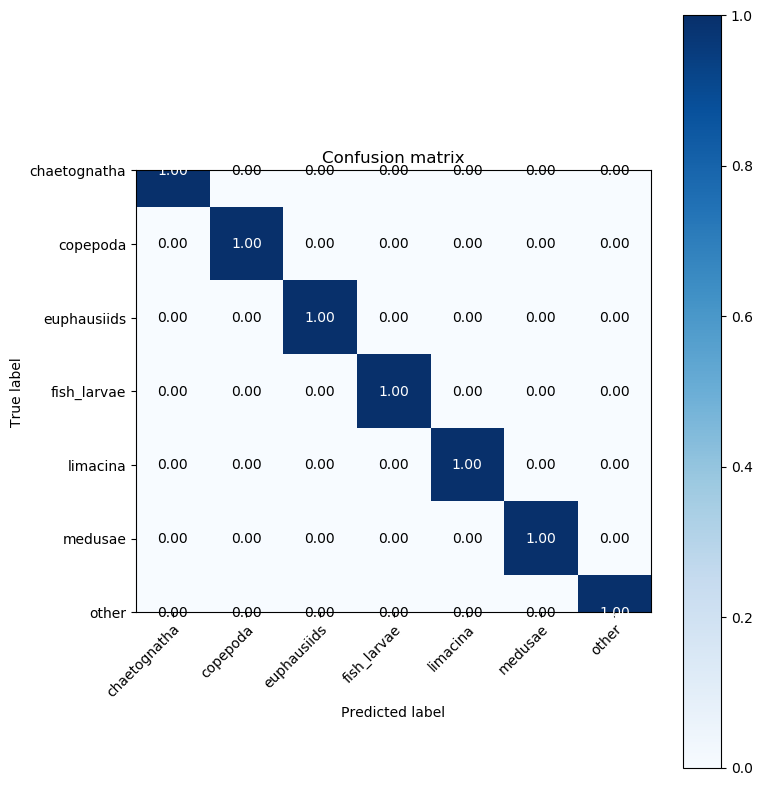

In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')
labels = ["chaetognatha","copepoda","euphausiids","fish_larvae","limacina","medusae","other"]
cm = confusion_matrix(Y_train, Y_hat_train)
cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=labels,yticklabels=labels,title="Confusion matrix",xlabel="Predicted label",ylabel="True label")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fmt = '.2f'
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [33]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
scores = cross_val_score(M, X_train, Y_train.ravel(), cv=5, scoring=make_scorer(scoring_function), n_jobs = -1)
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))


CV score (95 perc. CI): 0.79 (+/- 0.01)


<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [39]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

/bin/sh: 1: source: not found
Using input_dir: /home/paul/projects/OCEAN/starting_kit/public_data
Using output_dir: /home/paul/projects/OCEAN/starting_kit/sample_result_submission
Using program_dir: /home/paul/projects/OCEAN/starting_kit/ingestion_program
Using submission_dir: /home/paul/projects/OCEAN/starting_kit/sample_code_submission

========== Ingestion program version 6 ==========

************************************************
******** Processing dataset Plankton ********
************************************************
========= Reading and converting data ==========
Info file found : /home/paul/projects/OCEAN/starting_kit/public_data/plankton_public.info
========= Reading /home/paul/projects/OCEAN/starting_kit/public_data/plankton_feat.type
[+] Success in  0.00 sec
========= Reading /home/paul/projects/OCEAN/starting_kit/public_data/plankton_train.data
Replace missing values by 0 (slow, sorry)
[+] Success in  0.71 sec
========= Reading /home/paul/projects/OCEAN/starting_kit

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [40]:
scoring_output_dir = 'scoring_output'
!source activate python3; python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

/bin/sh: 1: source: not found
======= Set 1 (Plankton_train): balanced_accuracy_score(set1_score)=0.982421875000 =======


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.</div>

In [41]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = './sample_code_submission_' + the_date + '.zip'
sample_result_submission = './sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
./sample_code_submission_20-03-06-23-32.zip
./sample_result_submission_20-03-06-23-32.zip
